In [37]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [ ]:
from qutip import *
from qutip.measurement import measure, measurement_statistics
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import time
from tqdm.notebook import tqdm

def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))

    if isket(rho):  # ket状態を密度関数にする（必要かわからん）
        rho = ket2dm(rho)
    
    scale = np.sqrt(2)
    xvec = np.linspace(-5*scale,5*scale,100)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec/scale, xvec/scale, W, 60, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel('q', fontsize=16)
    ax.set_ylabel('p', fontsize=16)
    #ax.set_title()
    fig.tight_layout
    
    return fig, ax

In [41]:

def displace_np(alpha):
    op = alpha * adag - np.conjugate(alpha) * a
    return expm(op)

def squeeze_np(z):
    op = 1/2 * (np.conjugate(z) * a @ a - z * adag @ adag)
    return expm(op)

def rotation(phi):
    op = 1j * phi * adag @ a
    return expm(op)

def kerr(kappa):
    n = adag @ a
    op = 1j * kappa * n @ n
    return expm(op)


Error compiling Cython file:
------------------------------------------------------------
...
def displace_np(alpha):
    op = alpha * adag - np.conjugate(alpha) * a
                ^
------------------------------------------------------------

C:\Users\Ryosuke\.ipython\cython\_cython_magic_1dbc3abe301563da8dd4840e09b32849.pyx:2:17: undeclared name not builtin: adag

Error compiling Cython file:
------------------------------------------------------------
...
def displace_np(alpha):
    op = alpha * adag - np.conjugate(alpha) * a
                       ^
------------------------------------------------------------

C:\Users\Ryosuke\.ipython\cython\_cython_magic_1dbc3abe301563da8dd4840e09b32849.pyx:2:24: undeclared name not builtin: np

Error compiling Cython file:
------------------------------------------------------------
...
def displace_np(alpha):
    op = alpha * adag - np.conjugate(alpha) * a
                                             ^
---------------------------------------

In [42]:
def variational_quantum_circuit(params):
    s = time.perf_counter()
    # Gate layer: D-R-S-R-K
    def layer(i, phi):
        D = displace_np(params[i*7+0]*np.exp(1j*params[i*7+1]))
        R1 = rotation(params[i*7+2])
        S = squeeze_np(params[i*7+3]*np.exp(1j*params[i*7+4]))
        R2 = rotation(params[i*7+5])
        K = kerr(params[i*7+6])
        quantum_state = K @ D @ R2 @ S @ R1 @ phi
        return quantum_state
    
    # construct the circuit
    state = np.zeros(dim)
    state[0] = 1.0 # |0>状態を準備
    for i in range(depth):
        state = layer(i, state)
    e = time.perf_counter()  
    #print('time',e-s)
    return state, e-s


Error compiling Cython file:
------------------------------------------------------------
...
def variational_quantum_circuit(params):
    s = time.perf_counter()
       ^
------------------------------------------------------------

C:\Users\Ryosuke\.ipython\cython\_cython_magic_e9cef08c5648199cda53c547ac4611b9.pyx:2:8: undeclared name not builtin: time

Error compiling Cython file:
------------------------------------------------------------
...
        K = kerr(params[i*7+6])
        quantum_state = K @ D @ R2 @ S @ R1 @ phi
        return quantum_state
    
    # construct the circuit
    state = np.zeros(dim)
           ^
------------------------------------------------------------

C:\Users\Ryosuke\.ipython\cython\_cython_magic_e9cef08c5648199cda53c547ac4611b9.pyx:14:12: undeclared name not builtin: np

Error compiling Cython file:
------------------------------------------------------------
...
        K = kerr(params[i*7+6])
        quantum_state = K @ D @ R2 @ S @ R1 @ phi
  

In [43]:
dim = 50
depth = 8

_a = destroy(dim)
_adag = _a.dag()
a = _a.full()
adag = _adag.full()

t = np.zeros(100)
for i in tqdm(range(100)):
    params = np.random.normal(0, 0.1, [7*depth]) # 最初のパラメータ
    state, t[i] = variational_quantum_circuit(params)
print('avg',np.sum(t/100))


Error compiling Cython file:
------------------------------------------------------------
...
dim = 50
depth = 8

_a = destroy(dim)
    ^
------------------------------------------------------------

C:\Users\Ryosuke\.ipython\cython\_cython_magic_e4dec949f0af8c1c2ef0c500574eff5f.pyx:4:5: undeclared name not builtin: destroy

Error compiling Cython file:
------------------------------------------------------------
...
_a = destroy(dim)
_adag = _a.dag()
a = _a.full()
adag = _adag.full()

t = np.zeros(100)
   ^
------------------------------------------------------------

C:\Users\Ryosuke\.ipython\cython\_cython_magic_e4dec949f0af8c1c2ef0c500574eff5f.pyx:9:4: undeclared name not builtin: np

Error compiling Cython file:
------------------------------------------------------------
...
_adag = _a.dag()
a = _a.full()
adag = _adag.full()

t = np.zeros(100)
for i in tqdm(range(100)):
        ^
------------------------------------------------------------

C:\Users\Ryosuke\.ipython\cython\_cyth

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='q', ylabel='p'>)

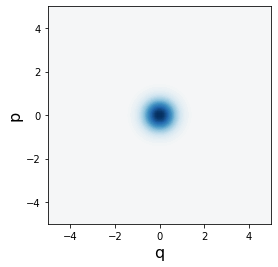

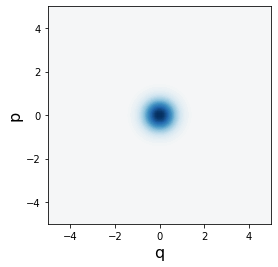

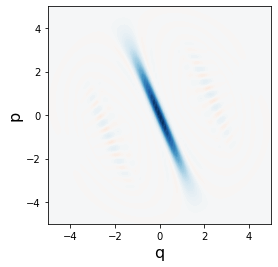

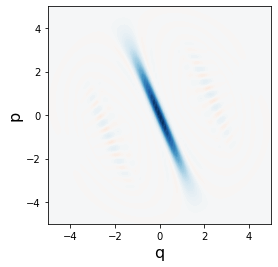

In [9]:
state_np = np.zeros(dim)
state_np[0] = 1
state_qobj = fock(dim, 0)
plot_wigner(Qobj(state_np))
plot_wigner(state_qobj)

alpha = 1 + 1j
state1_np = kerr(alpha) @ state_np
state1_qobj = squeeze(dim, alpha) * state_qobj
plot_wigner(Qobj(state1_np))
plot_wigner(state1_qobj)